In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
df = pd.read_csv("train.csv")
df.head()
X,Y = df.loc[:,"Statement"].values,df.loc[:,"Label"].values

In [0]:
def is_noun(pos):
  return pos[:2]=="NN"  
def keyword_inventory(doc,vocabulary=None):
  stemmer = nltk.stem.SnowballStemmer("english")
  key_select , key_roots,cat_keys,count_kwds = dict(),dict(),list(),dict()
  for s in doc:
    lines = s.lower()
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word,pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
  
    for t in nouns:
      root = stemmer.stem(t)
      if root in key_roots:
        key_roots[root].add(t)
        count_kwds[root]+=1

      else:
        key_roots[root] = {t}
        count_kwds[root] = 1
  for s in key_roots.keys():
    raccine = key_roots[s]
    if len(raccine) > 1:
      min_length = 1000
      for k in raccine:
        if len(k)<min_length:
          clef = k;min_length = len(k)
      key_select[s] = clef
      cat_keys.append(clef)
    else:
      cat_keys.append(list(key_roots[s])[0])
      key_select[s] = list(key_roots[s])[0]
  return key_roots,key_select,cat_keys,count_kwds         

In [0]:
# Taking output from keyword inventory
key_select,key_roots,cat_keys,count_kwds = keyword_inventory(X)

In [0]:
vocab = cat_keys

In [0]:
# Making pipeline for Our Model
pipe = Pipeline([("tfidf",TfidfVectorizer(vocabulary=vocab)),
                 ("randomforest",RandomForestClassifier(n_estimators=500))])


In [111]:
pipe.fit(X,Y)

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True,
                  vocabulary=['annies', 'group', 'third-trimester', 'abortion',
                              'demand', 'decline', 'coal', 'start', 'gas',
                              'president', 'george', 'w.', 'bush',
                              'administrator', 'clinton', 'john', 'mccain',
                              'benefit', 'doubt', 'iran', 'health', 'care',
                              'reform', 'legislator', 'sex', 'change', 'surgery',
                              'turnaround

Testing of the trained Model

In [54]:
df_test = pd.read_csv("test.csv")
df_test.head()

,Statement,Label
0,Building a wall on the U.S.-Mexico border will...,True
1,Wisconsin is on pace to double the number of l...,False
2,Says John McCain has done nothing to help the ...,False
3,Suzanne Bonamici supports a plan that will cut...,True
4,When asked by a reporter whether hes at the ce...,False


In [0]:
X_test,Y_test = df_test.loc[:,"Statement"].values,df_test.loc[:,"Label"].values
 

In [0]:
y_pred = pipe.predict(X_test)

In [59]:
# Calculating r2_score for our model
Y_test = np.where(Y_test==True,1,0)
y_pred = np.where(y_pred==True,1,0)
r2_score(Y_test,y_pred)

-0.6263916244418337

In [60]:
# Getting accuracy of our model.
np.mean(y_pred==Y_test)

0.5962367698941592

In [0]:
# testing on a custom given statement
statement = ["America will soon be going to be on its knees"]
prediction = pipe.predict(statement)

In [62]:
prediction

array([False])

In [0]:
# Saving our model
import pickle
pickle.dump(pipe,open("FakeNewsDetection.pkl","wb"),protocol=4)

### Now we are evaluating the model

In [0]:
a = confusion_matrix(y_pred,Y_test)

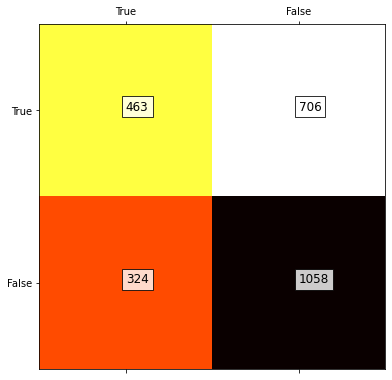

In [87]:
# Plotting our confusion matrix
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0.1,0.1,1.6,1.6])

ax.matshow(a,cmap="hot_r")
for i in range(len(a)):
  for j in range(len(a)):
    ax.text(i,j,s=a[i][j],bbox=dict(facecolor="white",alpha=0.8),fontsize=12)
ax.set_xticklabels([" ","True","False"])
ax.set_yticklabels([" ","True","False"])
plt.show()

In [0]:
# Printing out its classification report
clf_report = classification_report(Y_test,y_pred) 

In [99]:
clf_report.rstrip().split("\n")

['              precision    recall  f1-score   support',
 '',
 '           0       0.59      0.40      0.47      1169',
 '           1       0.60      0.77      0.67      1382',
 '',
 '    accuracy                           0.60      2551',
 '   macro avg       0.59      0.58      0.57      2551',
 'weighted avg       0.59      0.60      0.58      2551']

In [0]:
# Last but not least calculating the cross_val_score
result = cross_val_score(pipe,X,Y,scoring="accuracy",cv=10)

In [105]:
result

array([0.59765625, 0.60253906, 0.57421875, 0.61425781, 0.59082031,
       0.60839844, 0.60742188, 0.56738281, 0.58886719, 0.625     ])

Hence the maximum accuracy we got on the 10th fold .

In [0]:
clf = pickle.load(open("FakeNewsDetection.pkl","rb"),encoding="utf-8")

array([ True])